# Многоуровневая оптимизация
## Синтетический эксперемент: Минимизация функции Розенброка с помощью:

Low-fidelity (быстрая, шумная, приближённая)

High-fidelity (медленная, точная)

Использование стратегии вроде MFBO (multi-fidelity Bayesian optimization)

Графики затрат / точности / итераций

## Реальный эксперемент (только финальные графики или табличные результаты)

Приоритезация стека расчетов ИМА из Оптима

In [15]:
# =====================================
# 📍 1. Импорты и конфигурация окружения
# =====================================
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mlflow
from typing import List, Tuple, Dict, Callable
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import time 
import numpy as np
from skopt import gp_minimize
from time import sleep
import matplotlib.pyplot as plt
from collections import namedtuple
from functools import partial

np.random.seed(42)

In [16]:
# =====================================
# 🧪 2. Определение целевой функции
# =====================================

# Синтетическая задача: функция Розенброка, Растригина

def rosenbrock(x: list, noise=0.0, a = 1, b = 100):
    """
    Вычисляет значение функции Розенброка для заданного вектора x.

    Аргументы:
        x: Список или кортеж, представляющий точку в n-мерном пространстве.

    Возвращает:
        Значение функции Розенброка в точке x.
    """
    a = a
    b = b
    sum_val = 0
    for i in range(len(x) - 1):
        sum_val += (a - x[i])**2 + b * (x[i+1] - x[i]**2)**2
    return sum_val



def rastrigin(x: list, noise=0.0, A = 10):
    """
    Вычисляет значение функции Растригина для заданного вектора x.

    Аргументы:
        x: Список или кортеж, представляющий точку в n-мерном пространстве.

    Возвращает:
        Значение функции Растригина в точке x.
    """
    x = np.array(x)
    n = len(x)
    
    sum_val = 0
    sum_val += np.sum(x**2 - A * np.cos(2 * np.pi * x))
    return A * n + sum_val + np.random.normal(0, noise)


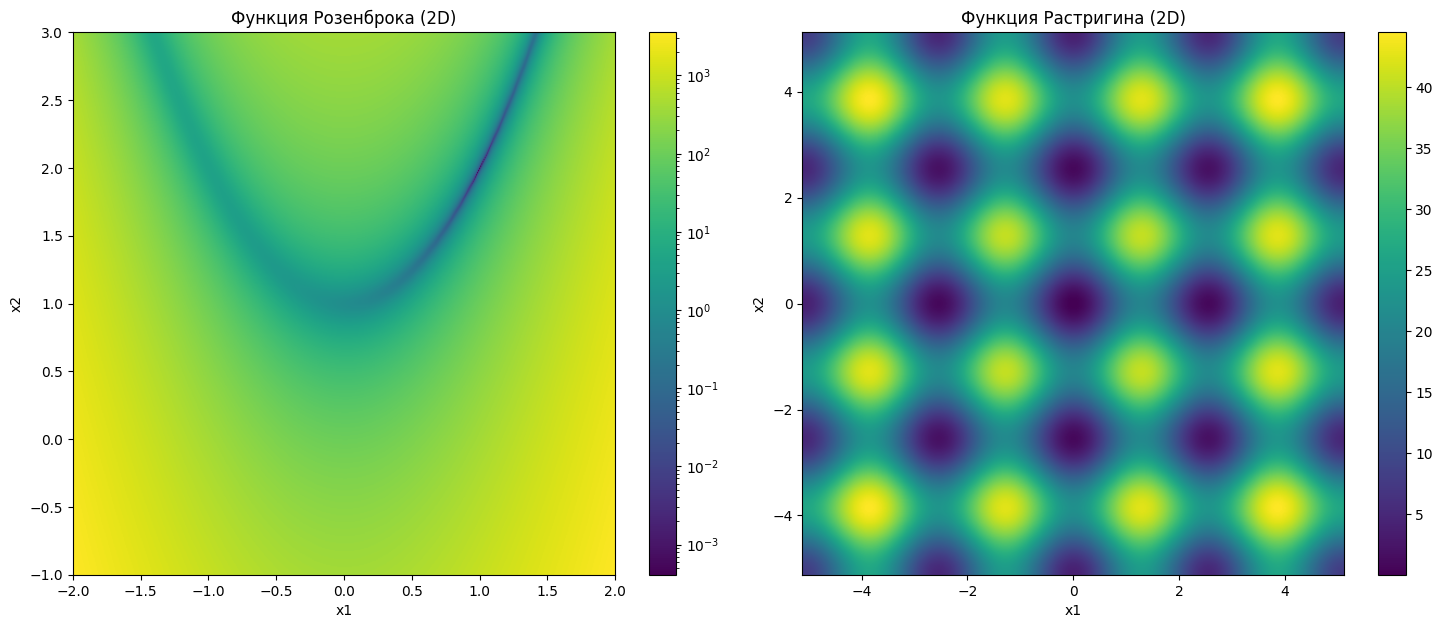

In [17]:
# =====================================
# 📊 3. Визуализация функций
# =====================================

# Построим контурные графики и сравним

def plot_2d_functions():
    # Создаем сетку для построения
    x = np.linspace(-2, 2, 500)
    y = np.linspace(-2, 2, 500)
    X, Y = np.meshgrid(x, y)
    
    # Вычисляем значения функций
    Z_rosenbrock = np.array([rosenbrock([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
    Z_rastrigin = np.array([rastrigin([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
    
    # Настройка графики
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # График функции Розенброка
    im1 = ax1.imshow(Z_rosenbrock, extent=[-2, 2, -1, 3], 
                    origin='lower', norm=LogNorm(), cmap='viridis')
    ax1.set_title('Функция Розенброка (2D)')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    fig.colorbar(im1, ax=ax1)
    
    # График функции Растригина
    im2 = ax2.imshow(Z_rastrigin, extent=[-5.12, 5.12, -5.12, 5.12], 
                    origin='lower', cmap='viridis')
    ax2.set_title('Функция Растригина (2D)')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    fig.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Запуск визуализации
plot_2d_functions()

In [20]:
# 2. Эмуляторы fidelity с исправлениями
def create_surrogate_function(target_fun, noise=0.0, delay=0.0):
    def surrogate_function(x):
        sleep(delay)
        return target_fun(x, noise=noise)
    return surrogate_function

def fidelity_function(base_func, level: int):
    noise_levels = {1: 0.01, 2: 0.1, 3: 0.5}
    delay_levels = {1: 0.1, 2: 0.03, 3: 0.005}  # Вместо 1.0, 0.3, 0.05
    return create_surrogate_function(base_func, noise_levels[level], delay_levels[level])

mlflow ui

http://localhost:5000

In [21]:
# 3. Функции оптимизации с исправлениями
def refine_bounds(center, original_bounds, factor=0.2):
    center = np.array(center)
    new_bounds = []
    for i, (low, high) in enumerate(original_bounds):
        width = (high - low) * factor
        new_low = max(low, center[i] - width/2)
        new_high = min(high, center[i] + width/2)
        new_bounds.append((new_low, new_high))
    return new_bounds

def random_search(func, bounds, n_calls):
    """Альтернатива gp_minimize для малого бюджета"""
    dim = len(bounds)
    best_x = None
    best_y = float('inf')
    history = []
    
    for _ in range(n_calls):
        x = np.array([np.random.uniform(low, high) for (low, high) in bounds])
        y = func(x)
        history.append({'x': x, 'y': y})
        if y < best_y:
            best_y = y
            best_x = x
            
    OptimizeResult = namedtuple('OptimizeResult', ['x', 'fun', 'x_iters'])
    return OptimizeResult(x=best_x, fun=best_y, x_iters=[h['x'] for h in history])

def run_optimization(surrogate, bounds, n_calls):
    """Универсальный оптимизатор с проверкой бюджета"""
    if n_calls < 10:
        return random_search(surrogate, bounds, n_calls)
    else:
        return gp_minimize(
            surrogate,
            bounds,
            n_calls=n_calls,
            random_state=42,
            n_initial_points=min(10, n_calls)  # Автоподстройка под бюджет
        )

def hf_only_optimization(target_func, bounds, budget):
    hf_surrogate = fidelity_function(target_func, level=1)
    res = run_optimization(hf_surrogate, bounds, budget)
    return {
        'x': res.x,
        'y': res.fun,
        'calls': [{'x': x, 'fidelity': 1} for x in res.x_iters]
    }

def lf_only_optimization(target_func, bounds, budget):
    lf_surrogate = fidelity_function(target_func, level=3)
    res = run_optimization(lf_surrogate, bounds, budget)
    return {
        'x': res.x,
        'y': res.fun,
        'calls': [{'x': x, 'fidelity': 3} for x in res.x_iters]
    }

def hybrid_optimization(target_func, bounds, total_cost_budget=15):
    cost_weights = {1: 1.0, 2: 0.3, 3: 0.1}
    
    # Автоподстройка бюджета под требования skopt
    n_calls_lf = max(10, int(0.5 * total_cost_budget / cost_weights[3]))
    n_calls_mf = max(10, int(0.3 * total_cost_budget / cost_weights[2]))
    n_calls_hf = max(3, int(0.2 * total_cost_budget / cost_weights[1]))
    
    # LF этап
    lf_surrogate = fidelity_function(target_func, level=3)
    lf_res = run_optimization(lf_surrogate, bounds, n_calls_lf)
    
    # MF этап
    mf_surrogate = fidelity_function(target_func, level=2)
    refined_bounds = refine_bounds(lf_res.x, bounds, factor=0.5)
    mf_res = run_optimization(mf_surrogate, refined_bounds, n_calls_mf)
    
    # HF этап
    hf_surrogate = fidelity_function(target_func, level=1)
    final_bounds = refine_bounds(mf_res.x, refined_bounds, factor=0.3)
    hf_res = run_optimization(hf_surrogate, final_bounds, n_calls_hf)
    
    # Сбор результатов
    calls = (
        [{'x': x, 'fidelity': 3} for x in lf_res.x_iters] +
        [{'x': x, 'fidelity': 2} for x in mf_res.x_iters] +
        [{'x': x, 'fidelity': 1} for x in hf_res.x_iters]
    )
    
    return {
        'x': hf_res.x,
        'y': hf_res.fun,
        'calls': calls
    }


In [22]:

# 4. Функции сравнения и визуализации
def calculate_cost(calls):
    cost_weights = {1: 1.0, 2: 0.3, 3: 0.1}
    return sum(cost_weights[call['fidelity']] for call in calls)

def run_comparison_experiment(target_func, bounds, total_cost_budget=15):
    hf_budget = int(total_cost_budget / 1.0)
    lf_budget = int(total_cost_budget / 0.1)
    
    hf_result = hf_only_optimization(target_func, bounds, hf_budget)
    lf_result = lf_only_optimization(target_func, bounds, lf_budget)
    hybrid_result = hybrid_optimization(target_func, bounds, total_cost_budget)
    
    # Расчет фактической стоимости
    hf_result['cost'] = calculate_cost(hf_result['calls'])
    lf_result['cost'] = calculate_cost(lf_result['calls'])
    hybrid_result['cost'] = calculate_cost(hybrid_result['calls'])
    
    return {
        'hf_only': hf_result,
        'lf_only': lf_result,
        'hybrid': hybrid_result
    }
# 6. Визуализация результатов
def plot_results(results, true_minimum=0):
    strategies = ['hf_only', 'lf_only', 'hybrid']
    labels = ['HF Only', 'LF Only', 'Hybrid']
    colors = ['red', 'blue', 'green']
    
    # Точность
    plt.figure(figsize=(10, 6))
    errors = [abs(results[s]['y'] - true_minimum) for s in strategies]
    plt.bar(labels, errors, color=colors)
    plt.ylabel('Error |f_min - f_global|')
    plt.title('Optimization Accuracy')
    plt.savefig('accuracy_comparison.png')
    
    # Стоимость
    plt.figure(figsize=(10, 6))
    costs = [results[s]['cost'] for s in strategies]
    plt.bar(labels, costs, color=colors)
    plt.ylabel('Total Cost')
    plt.title('Optimization Cost')
    plt.savefig('cost_comparison.png')
    
    # Распределение вызовов (для гибридного)
    plt.figure(figsize=(8, 8))
    fidelities = [call['fidelity'] for call in results['hybrid']['calls']]
    counts = [fidelities.count(1), fidelities.count(2), fidelities.count(3)]
    plt.pie(counts, labels=['HF', 'MF', 'LF'], autopct='%1.1f%%')
    plt.title('Hybrid Approach: Fidelity Distribution')
    plt.savefig('fidelity_distribution.png')




HF Only: f=1.8093, cost=15.0
LF Only: f=0.0277, cost=15.0
Hybrid: f=2.3695, cost=15.0


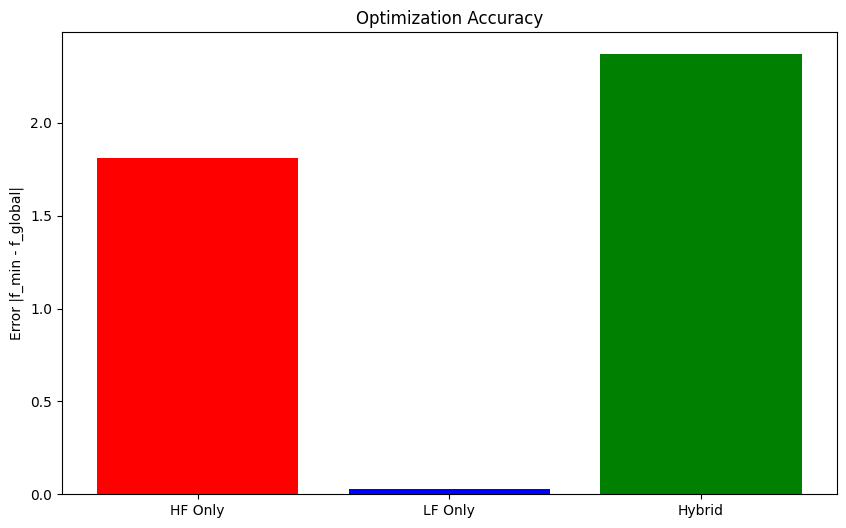

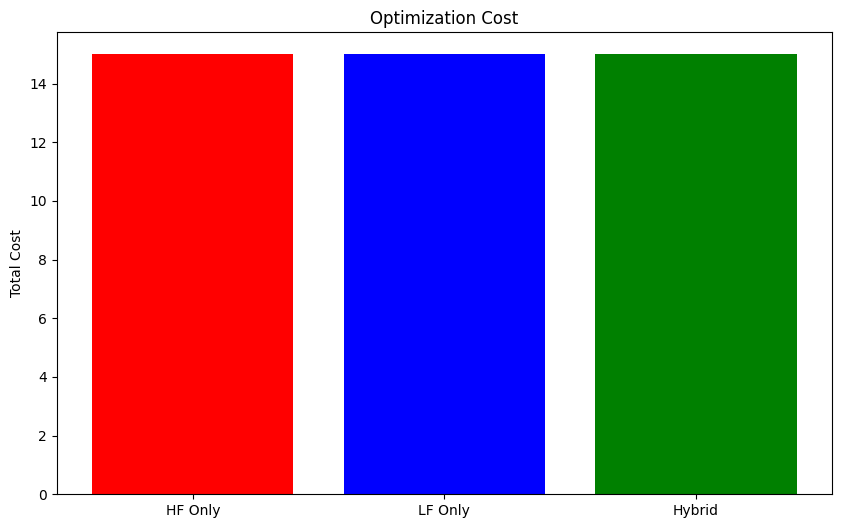

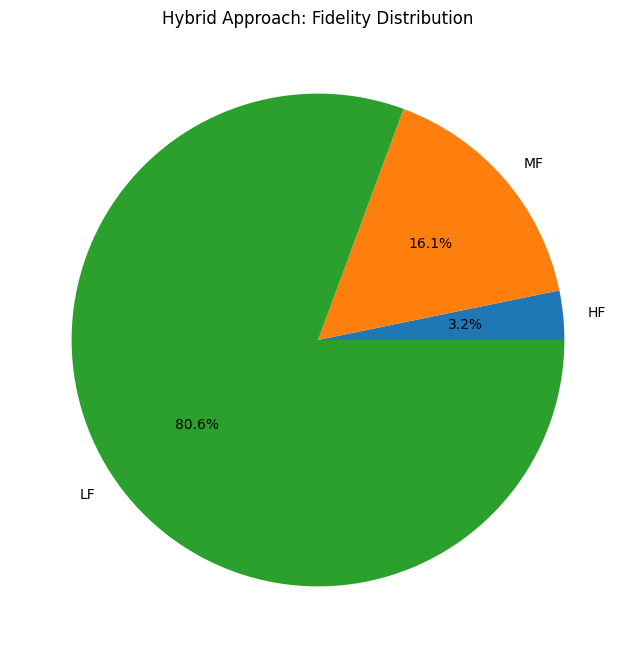

In [23]:
# 7. Основной запуск
# # Параметры эксперимента
bounds = [(-5.0, 5.0), (-5.0, 5.0)]  # 2D пространство
true_min = 0  # Глобальный минимум Rastrigin

# Запуск
results = run_comparison_experiment(rosenbrock, bounds, total_cost_budget=15)

# Анализ и визуализация
print(f"HF Only: f={results['hf_only']['y']:.4f}, cost={results['hf_only']['cost']:.1f}")
print(f"LF Only: f={results['lf_only']['y']:.4f}, cost={results['lf_only']['cost']:.1f}")
print(f"Hybrid: f={results['hybrid']['y']:.4f}, cost={results['hybrid']['cost']:.1f}")

plot_results(results, true_min)

In [2]:
import numpy as np
from time import sleep, time
from collections import defaultdict
import matplotlib.pyplot as plt

# 2. Эмуляторы fidelity с исправлениями (твоя реализация)

def create_surrogate_function(target_fun, noise=0.0, delay=0.0):
    """
    Возвращает функцию, которая эмулирует surrogate с заданным шумом и задержкой.
    Шум и задержка подаются явно.
    """
    def surrogate_function(x):
        if delay > 0:
            sleep(delay)
        return target_fun(x, noise=noise)
    return surrogate_function

def fidelity_function(base_func, level: int, noise=None, delay=None):
    """
    Возвращает surrogate-функцию заданного fidelity-уровня.
    По умолчанию для каждого уровня используются характерные значения шума/задержки,
    но можно явно задать noise и delay.
    """
    defaults = {
        1: {'noise': 0.01, 'delay': 0.1},  # High-fidelity
        2: {'noise': 0.1,  'delay': 0.01}, # Low-fidelity
    }
    params = defaults[level].copy()
    if noise is not None:
        params['noise'] = noise
    if delay is not None:
        params['delay'] = delay
    return create_surrogate_function(base_func, **params)

# Целевая функция без шума — для оценки "истинных" значений
def rosenbrock(x, noise=0.0, a=1, b=100):
    x = np.array(x)
    sum_val = np.sum((a - x[:-1]) ** 2 + b * (x[1:] - x[:-1] ** 2) ** 2)
    return sum_val + np.random.normal(0, noise)

# Сетка
def generate_grid(bounds, grid_size):
    x1 = np.linspace(bounds[0][0], bounds[0][1], grid_size)
    x2 = np.linspace(bounds[1][0], bounds[1][1], grid_size)
    grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)
    return grid

# HF Grid Search
def high_fidelity_grid_search(target_func, bounds, grid):
    hf_func = fidelity_function(target_func, level=1)
    best_x, best_y = None, float('inf')
    preds = []
    for x in grid:
        y = hf_func(x)
        preds.append((x, y))
        if y < best_y:
            best_x, best_y = x, y
    return {'x': best_x, 'y': best_y, 'preds': preds}

# LF Grid Search
def low_fidelity_grid_search(target_func, bounds, grid):
    lf_func = fidelity_function(target_func, level=2)
    preds = []
    for x in grid:
        y = lf_func(x)
        preds.append((x, y))
    # Лучшее по LF, но возвращаем HF-значение для этой точки
    best_lf_x, _ = min(preds, key=lambda tup: tup[1])
    hf_func = fidelity_function(target_func, level=1)
    best_hf_y = hf_func(best_lf_x)
    return {'x': best_lf_x, 'y': best_hf_y, 'preds': preds}

# MF Grid Search — шум LF уменьшается трижды, HF для лучших точек каждой стадии
def multifidelity_grid_search(target_func, bounds, grid, hf_period=0.33):
    lf_noise_levels = [0.5, 0.2, 0.05]
    stage_len = int(len(grid) * hf_period)
    stage_points = [stage_len, 2*stage_len, len(grid)]
    preds = []
    hf_func = fidelity_function(target_func, level=1)
    curr_noise_idx = 0
    lf_noise = lf_noise_levels[curr_noise_idx]

    for i, x in enumerate(grid):
        lf_func = create_surrogate_function(target_func, noise=lf_noise, delay=0.005)
        y = lf_func(x)
        preds.append((x, y))
        # Уменьшаем шум после каждой стадии
        if (i+1) in stage_points and curr_noise_idx < len(lf_noise_levels)-1:
            curr_noise_idx += 1
            lf_noise = lf_noise_levels[curr_noise_idx]
    # Находим лучшую точку по LF и возвращаем HF-значение для неё
    best_lf_x, _ = min(preds, key=lambda tup: tup[1])
    best_hf_y = hf_func(best_lf_x)
    return {'x': best_lf_x, 'y': best_hf_y, 'preds': preds}

# Метрики
def mae(true, pred):
    return np.mean(np.abs(true - pred))

def mape(true, pred):
    true = np.where(true == 0, 1e-8, true)
    return np.mean(np.abs((true - pred) / true)) * 100

# Эксперимент
def run_all_methods(target_func, bounds, grid_size=30):
    grid = generate_grid(bounds, grid_size)
    true_values = np.array([rosenbrock(x, noise=0.0) for x in grid])

    results = {}

    # HF
    t0 = time()
    res_hf = high_fidelity_grid_search(target_func, bounds, grid)
    elapsed_hf = time() - t0
    pred_hf = np.array([y for _, y in res_hf['preds']])
    results['hf'] = {
        'x': res_hf['x'],
        'y': res_hf['y'],
        'mae': mae(true_values, pred_hf),
        'mape': mape(true_values, pred_hf),
        'time': elapsed_hf
    }

    # LF
    t0 = time()
    res_lf = low_fidelity_grid_search(target_func, bounds, grid)
    elapsed_lf = time() - t0
    pred_lf = np.array([y for _, y in res_lf['preds']])
    results['lf'] = {
        'x': res_lf['x'],
        'y': res_lf['y'],
        'mae': mae(true_values, pred_lf),
        'mape': mape(true_values, pred_lf),
        'time': elapsed_lf
    }

    # MF
    t0 = time()
    res_mf = multifidelity_grid_search(target_func, bounds, grid, hf_period=0.33)
    elapsed_mf = time() - t0
    pred_mf = np.array([y for _, y in res_mf['preds']])
    results['mf'] = {
        'x': res_mf['x'],
        'y': res_mf['y'],
        'mae': mae(true_values, pred_mf),
        'mape': mape(true_values, pred_mf),
        'time': elapsed_mf
    }

    return results

# Запуск
bounds = [(-2, 2), (-1, 3)]
results = run_all_methods(rosenbrock, bounds, grid_size=30)

for key, res in results.items():
    print(f"\n{key.upper()} method:")
    print(f"  Найденная точка: {np.round(res['x'], 3)}")
    print(f"  Значение функции: {res['y']:.5f}")
    print(f"  Время, сек: {res['time']:.2f}")
    print(f"  MAE по сетке: {res['mae']:.4f}")
    print(f"  MAPE по сетке: {res['mape']:.2f}%")



HF method:
  Найденная точка: [1.034 1.069]
  Значение функции: 0.01338
  Время, сек: 93.48
  MAE по сетке: 0.0082
  MAPE по сетке: 1.13%

LF method:
  Найденная точка: [0.897 0.793]
  Значение функции: 0.02389
  Время, сек: 11.02
  MAE по сетке: 0.0780
  MAPE по сетке: 8.12%

MF method:
  Найденная точка: [0.621 0.379]
  Значение функции: 0.15652
  Время, сек: 5.70
  MAE по сетке: 0.2017
  MAPE по сетке: 5.21%


Эти эксперементы я хочу провести по 50 запусков и получить итоговые осредненныеметрики по ним

In [ ]:
import numpy as np
from time import sleep, time
import mlflow
import os

def create_surrogate_function(target_fun, noise=0.0, delay=0.0):
    def surrogate_function(x):
        if delay > 0:
            sleep(delay)
        return target_fun(x, noise=noise)
    return surrogate_function

def fidelity_function(base_func, level: int, noise=None, delay=None):
    defaults = {
        1: {'noise': 0.01, 'delay': 0.1},  # High-fidelity
        2: {'noise': 0.1,  'delay': 0.01}, # Low-fidelity
    }
    params = defaults[level].copy()
    if noise is not None:
        params['noise'] = noise
    if delay is not None:
        params['delay'] = delay
    return create_surrogate_function(base_func, **params)

def rosenbrock(x, noise=0.0, a=1, b=100):
    x = np.array(x)
    sum_val = np.sum((a - x[:-1]) ** 2 + b * (x[1:] - x[:-1] ** 2) ** 2)
    return sum_val + np.random.normal(0, noise)

def rastrigin(x, noise=0.0, A=10):
    x = np.array(x)
    n = len(x)
    sum_val = np.sum(x**2 - A * np.cos(2 * np.pi * x))
    return A * n + sum_val + np.random.normal(0, noise)

def generate_grid(bounds, grid_size):
    x1 = np.linspace(bounds[0][0], bounds[0][1], grid_size)
    x2 = np.linspace(bounds[1][0], bounds[1][1], grid_size)
    grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)
    return grid

def high_fidelity_grid_search(target_func, grid):
    hf_func = fidelity_function(target_func, level=1)
    best_x, best_y = None, float('inf')
    preds = []
    for x in grid:
        y = hf_func(x)
        preds.append((x, y))
        if y < best_y:
            best_x, best_y = x, y
    return {'x': best_x, 'y': best_y, 'preds': preds}

def low_fidelity_grid_search(target_func, grid):
    lf_func = fidelity_function(target_func, level=2)
    preds = []
    for x in grid:
        y = lf_func(x)
        preds.append((x, y))
    best_lf_x, _ = min(preds, key=lambda tup: tup[1])
    hf_func = fidelity_function(target_func, level=1)
    best_hf_y = hf_func(best_lf_x)
    return {'x': best_lf_x, 'y': best_hf_y, 'preds': preds}

def multifidelity_grid_search(target_func, grid, initial_noise=0.5, alpha=0.9, noise_update_period=20):
    noise = initial_noise
    delay = 0.01
    preds = []
    for i, x in enumerate(grid):
        lf_func = fidelity_function(target_func, level=2, noise=noise, delay=delay)
        y = lf_func(x)
        preds.append((x, y))
        if (i+1) % noise_update_period == 0:
            noise = max(noise * alpha, 0.01)
    best_lf_x, _ = min(preds, key=lambda tup: tup[1])
    hf_func = fidelity_function(target_func, level=1)
    best_hf_y = hf_func(best_lf_x)
    return {'x': best_lf_x, 'y': best_hf_y, 'preds': preds}

def mae(true, pred):
    return np.mean(np.abs(true - pred))

def mape(true, pred):
    true = np.where(true == 0, 1e-8, true)
    return np.mean(np.abs((true - pred) / true)) * 100

def run_one_experiment(target_func, func_name, bounds, grid_size=22, mf_alpha=0.9, mf_period=20):
    np.random.seed()
    grid = generate_grid(bounds, grid_size)
    true_values = np.array([target_func(x, noise=0.0) for x in grid])

    # HF
    t0 = time()
    res_hf = high_fidelity_grid_search(target_func, grid)
    elapsed_hf = (time() - t0) / 60  # в минутах
    pred_hf = np.array([y for _, y in res_hf['preds']])

    # LF
    t0 = time()
    res_lf = low_fidelity_grid_search(target_func, grid)
    elapsed_lf = (time() - t0) / 60  # в минутах
    pred_lf = np.array([y for _, y in res_lf['preds']])

    # MF
    t0 = time()
    res_mf = multifidelity_grid_search(target_func, grid, alpha=mf_alpha, noise_update_period=mf_period)
    elapsed_mf = (time() - t0) / 60  # в минутах
    pred_mf = np.array([y for _, y in res_mf['preds']])

    return {
        'func': func_name,
        'hf': {
            'x': res_hf['x'],
            'y': res_hf['y'],
            'mae': mae(true_values, pred_hf),
            'mape': mape(true_values, pred_hf),
            'time': elapsed_hf
        },
        'lf': {
            'x': res_lf['x'],
            'y': res_lf['y'],
            'mae': mae(true_values, pred_lf),
            'mape': mape(true_values, pred_lf),
            'time': elapsed_lf
        },
        'mf': {
            'x': res_mf['x'],
            'y': res_mf['y'],
            'mae': mae(true_values, pred_mf),
            'mape': mape(true_values, pred_mf),
            'time': elapsed_mf
        }
    }

# ==== MLflow batch run ====
EXPERIMENT_NAME = "Multifidelity_GridSearch_Experiment"
mlflow.set_experiment(EXPERIMENT_NAME)
results_list = []

# Конфиг экспериментальных параметров
bounds = [(-5, 5), (-5, 5)]
grid_size = 22   # чтобы целые числа были в сетке
n_runs = 50

# Выбрать функцию для эксперимента
target_func = rosenbrock  # или rastrigin
func_name = target_func.__name__

for seed in range(n_runs):
    with mlflow.start_run(run_name=f"run_{seed}_{func_name}"):
        result = run_one_experiment(target_func, func_name, bounds, grid_size, mf_alpha=0.9, mf_period=20)
        results_list.append(result)
        mlflow.log_param("function", func_name)
        mlflow.log_param("grid_size", grid_size)
        mlflow.log_param("bounds", str(bounds))
        mlflow.log_param("mf_alpha", 0.9)
        mlflow.log_param("mf_period", 20)

        for key in ['hf', 'lf', 'mf']:
            mlflow.log_metric(f"{key}_y", result[key]['y'])
            mlflow.log_metric(f"{key}_mae", result[key]['mae'])
            mlflow.log_metric(f"{key}_mape", result[key]['mape'])
            mlflow.log_metric(f"{key}_time_minutes", result[key]['time'])
            np.save(f"{key}_best_x_run{seed}.npy", result[key]['x'])
            mlflow.log_artifact(f"{key}_best_x_run{seed}.npy")
            os.remove(f"{key}_best_x_run{seed}.npy")

# === Усреднение по всем ранам ===
means = {}
for key in ['hf', 'lf', 'mf']:
    y = np.array([res[key]['y'] for res in results_list])
    mae_arr = np.array([res[key]['mae'] for res in results_list])
    mape_arr = np.array([res[key]['mape'] for res in results_list])
    time_arr = np.array([res[key]['time'] for res in results_list])
    means[key] = {
        'y': np.mean(y),
        'mae': np.mean(mae_arr),
        'mape': np.mean(mape_arr),
        'time': np.mean(time_arr)
    }

print(f"\n=== Усреднённые результаты по 50 ранам для функции {func_name} ===")
for key in ['hf', 'lf', 'mf']:
    print(f"\n{key.upper()} method (среднее по 50 запусков):")
    print(f"  Среднее значение в найденной точке: {means[key]['y']:.5f}")
    print(f"  MAE по сетке: {means[key]['mae']:.4f}")
    print(f"  MAPE по сетке: {means[key]['mape']:.2f}%")
    print(f"  Время, мин: {means[key]['time']:.3f}")
